#### Plan for synthetic data 
1. Create synthetic datasets
2. Run synthetic unbiased fair synthetic dataset
3. add in error + bias into Y-train, make it rely on S
4. run pipeline on new data and try to get it to meet the same baseline as the original dataset for demographic parity + accuracy.

#### Additional work 
hypertune for lambda so that accuracy and demographic parity are well balanced.

In [2]:
# !pip install fairlearn

import pandas as pd 
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
import random
import datetime

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, 
    MaxPooling2D, BatchNormalization, Dropout
)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler
)
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.optimizers import Adam
from keras.initializers import Constant

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, 
    MaxPooling2D, BatchNormalization, Dropout, Concatenate
)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler
)

from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

2025-03-01 14:56:25.314270: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-01 14:56:25.314303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-01 14:56:25.315935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 14:56:25.324401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# -------------------------------
# Custom Gradient Reversal Layer
# -------------------------------
@tf.custom_gradient
def grad_reverse(x, lambda_):
    def grad(dy):
        return -lambda_ * dy, None # reverses direction of gradient 
    return x, grad

# custom Keras layer
"""
Layer is used to ensure that the feature representation are independent of a sensitive attribute
- feature extract learns normally in the forward pass
- reversing gradients of classifier that tries to predict the sensitive attribute during backpropagation -- stops feature extractor from encoding sensitive information
"""
class GradientReversalLayer(tf.keras.layers.Layer): 
    def __init__(self, lambda_=1.0, **kwargs):
        super(GradientReversalLayer, self).__init__(**kwargs)
        self.lambda_ = lambda_ # strength of gradient reversal
    def call(self, x):
        return grad_reverse(x, self.lambda_)

# -------------------------------
# Data Loading and Preprocessing
# -------------------------------
def set_seed(seed_num):
    random.seed(seed_num)
    np.random.seed(seed_num)
    tf.random.set_seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)

In [4]:
# -------------------------------
# Adversarial Debiasing Model
# -------------------------------
def build_adversarial_model(input_dim, lambda_adv=1.0):
    """
    Build an adversarial debiasing model that learns pseudo‑labels Y' from X.

    Architecture:
      - Main branch (encoder): from X, several dense layers produce a latent pseudo‑label pseudo_Y (via softmax for multi-class).
      - Adversary branch: pseudo_Y is passed through a Gradient Reversal Layer and then dense layers predict S.
      - Decoder branch: concatenates pseudo_Y and the one-hot sensitive attribute S to predict the observed label Y.

    Losses:
      - For the main branch, categorical crossentropy between observed Y and pseudo_Y (and Y_pred).
      - For the adversary branch, categorical crossentropy to predict S.

    Returns a compiled Keras model that takes inputs X and S (one-hot encoded) and outputs:
      [pseudo_Y, S_pred, Y_pred].
    """
    X_input = tf.keras.Input(shape=(input_dim,), name="X")
    S_input = tf.keras.Input(shape=(2,), name="S")  # one-hot encoded S

    # Main branch: Encoder for pseudo-label.
    h = Dense(64, activation='relu')(X_input)
    h = BatchNormalization()(h)
    h = Dense(32, activation='relu')(h)
    h = BatchNormalization()(h)
    pseudo_Y = Dense(4, activation='softmax', name="pseudo_Y")(h)  # Multi-class pseudo-labels

    # Adversary branch: from pseudo_Y, with GRL.
    """
    This prevents pseudo_Y from encoding information about S.
    - The adversary will try to predict S from pseudo_Y (fair label). If it can accurately predict S, then pseudo_Y still encodes S (which we want to prevent).
    - Use the gradient reversal layer to counteract this effect.
    """
    grl = GradientReversalLayer(lambda_=lambda_adv)(pseudo_Y)
    a = Dense(32, activation='relu')(grl)
    a = BatchNormalization()(a)
    S_pred = Dense(2, activation='softmax', name="S_pred")(a)  # Binary classification for S

    # Decoder branch: combine pseudo_Y and S to predict observed Y.
    """
    Y depends on both pseudo_Y and S.
    - Predict the final observed label Y using both pseudo_Y and S.
    - Ensures pseudo_Y is not directly influenced by S while still allowing S to contribute to Y_pred.
    - Maintains fair dependencies while eliminating unfair ones.
    """
    concat = Concatenate()([pseudo_Y, S_input])
    d = Dense(16, activation='relu')(concat)
    d = BatchNormalization()(d)
    Y_pred = Dense(4, activation='softmax', name="Y_pred")(d)  # Multi-class output

    model = tf.keras.Model(inputs=[X_input, S_input],
                           outputs=[pseudo_Y, S_pred, Y_pred])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss={"pseudo_Y": "categorical_crossentropy",  # Changed to categorical
                        "S_pred": "categorical_crossentropy",
                        "Y_pred": "categorical_crossentropy"},  # Changed to categorical
                  loss_weights={"pseudo_Y": 1.0, "S_pred": lambda_adv, "Y_pred": 1.0},
                  metrics={"pseudo_Y": "accuracy",
                           "S_pred": "accuracy",
                           "Y_pred": "accuracy"})  # Multi-class accuracy

    return model

In [5]:
# -------------------------------
# Manual Fairness Metrics
# -------------------------------
def compute_fairness_metrics_manual(y_true, y_pred, sensitive_features):
    """
    Compute fairness metrics manually for multi-class classification.
    
    y_true: ground-truth labels (1-D numpy array with class values 0,1,2,3).
    y_pred: predicted class probabilities (2-D numpy array with shape (n_samples, 4)).
    sensitive_features: 1-D numpy array (0 or 1).

    Returns a dictionary with:
      - Demographic parity difference (absolute difference in selection rates across groups).
      - Equalized odds difference (average difference in per-class TPR and FPR across groups).
      - Selection rates per group.
      - Group-wise accuracy.
    """
    y_pred_class = np.argmax(y_pred, axis=1)  # Convert softmax probabilities to class predictions
    groups = np.unique(sensitive_features)

    # Demographic Parity (Class-wise selection rate difference)
    """
    All groups (from the sensitive feature) should receive predictions at similar rates for each class.
    Computes the absolute difference in selection rates per class between S=0 and S=1.
    """
    pos_rates = {g: np.zeros(4) for g in groups}  # Store selection rates for each class (0,1,2,3)
    for g in groups:
        for c in range(4):  # Iterate through classes
            pos_rates[g][c] = np.mean(y_pred_class[sensitive_features == g] == c)

    dp_diff = np.mean(np.abs(pos_rates[0] - pos_rates[1]))  # Average difference across all classes

    # Equalized Odds (Per-Class TPR and FPR comparison across groups)
    """
    Ensuring that different groups in the sensitive feature have similar TPR and FPR rates for each class.
    This prevents the model from favoring certain groups in errors.
    """
    metrics = {g: {'tpr': np.zeros(4), 'fpr': np.zeros(4)} for g in groups}
    
    for g in groups:
        mask = (sensitive_features == g)
        y_true_g = y_true[mask]
        y_pred_g = y_pred_class[mask]

        for c in range(4):
            tp = np.sum((y_pred_g == c) & (y_true_g == c))
            fn = np.sum((y_pred_g != c) & (y_true_g == c))
            fp = np.sum((y_pred_g == c) & (y_true_g != c))
            tn = np.sum((y_pred_g != c) & (y_true_g != c))
            
            tpr = tp / (tp + fn + 1e-8)  # True Positive Rate for class c
            fpr = fp / (fp + tn + 1e-8)  # False Positive Rate for class c
            
            metrics[g]['tpr'][c] = tpr
            metrics[g]['fpr'][c] = fpr

    # Compute the Equalized Odds Difference as the average absolute difference in TPR and FPR across all classes
    eo_diff = np.mean(np.abs(metrics[0]['tpr'] - metrics[1]['tpr'])) + np.mean(np.abs(metrics[0]['fpr'] - metrics[1]['fpr']))

    # Selection Rate Per Group
    """
    Proportion of samples predicted as each class for each group.
    A higher selection rate for certain classes in one group may indicate bias.
    """
    sel_rate = {g: pos_rates[g].tolist() for g in groups}

    # Group-wise Accuracy
    """
    For each group in the sensitive feature, compute the accuracy to ensure consistent performance.
    """
    group_acc = {}
    for g in groups:
        mask = (sensitive_features == g)
        group_acc[g] = accuracy_score(y_true[mask], y_pred_class[mask])

    return {
        "demographic_parity_difference": dp_diff,
        "equalized_odds_difference": eo_diff,
        "selection_rate": sel_rate,
        "group_accuracy": group_acc
    }


In [6]:
# -------------------------------
# Plotting Function
# -------------------------------
def plot_comparison(metrics_baseline, metrics_fair):
    """
    Parameters:
    - metrics_baseline: Dictionary storing evaluation metrics for the baseline model.
    - metrics_fair: Dictionary storing evaluation metrics for the fair model.

    Plots a comparison of key fairness and performance metrics.
    """

    models = ['Baseline', 'Fair']
    
    # Ensure AUC is correctly computed for multi-class
    aucs = [metrics_baseline.get('auc', 0), metrics_fair.get('auc', 0)]
    accs = [metrics_baseline.get('accuracy', 0), metrics_fair.get('accuracy', 0)]
    dp_diff = [metrics_baseline.get("demographic_parity_difference", 0), 
               metrics_fair.get("demographic_parity_difference", 0)]
    eo_diff = [metrics_baseline.get("equalized_odds_difference", 0), 
               metrics_fair.get("equalized_odds_difference", 0)]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Multi-Class AUC (Make sure it's properly calculated elsewhere)
    axs[0,0].bar(models, aucs, color=['blue', 'green'])
    axs[0,0].set_title('Multi-Class AUC')
    axs[0,0].set_ylim([0, 1])

    # Accuracy comparison
    axs[0,1].bar(models, accs, color=['blue', 'green'])
    axs[0,1].set_title('Accuracy')
    axs[0,1].set_ylim([0, 1])

    # Demographic Parity Difference (Lower is better)
    axs[1,0].bar(models, dp_diff, color=['orange', 'purple'])
    axs[1,0].set_title('Demographic Parity Difference')

    # Equalized Odds Difference (Lower is better)
    axs[1,1].bar(models, eo_diff, color=['orange', 'purple'])
    axs[1,1].set_title('Equalized Odds Difference')

    plt.suptitle("Comparison: Baseline (X → Y) vs. Fair (X → Y') Model")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [7]:
def generate_synthetic_data(n_samples=5000, n_features=30, bias_factor=0.3, noise_level=0.1, seed=42):
    np.random.seed(seed)

    # Generate Sensitive Attribute S ~ Binomial(1, 0.5)
    S = np.random.binomial(1, 0.5, size=n_samples)

    # Generate Features X: Some function of S + Gaussian noise
    X = np.random.randn(n_samples, n_features) + 0.5 * S[:, np.newaxis]

    # Generate True Labels Y (linear function of X + noise)
    true_weights = np.random.randn(n_features)
    Y_continuous = X @ true_weights + np.random.normal(0, noise_level, size=n_samples)

    # Convert Y into four discrete categories
    bins = np.percentile(Y_continuous, [25, 50, 75])  # 3 cut points create 4 bins
    Y = np.digitize(Y_continuous, bins=bins)  # Bins index (0,1,2,3)

    # Ensure Y is properly categorical
    Y = Y.astype(int)

    # Split the dataset
    X_train, X_test, Y_train_obs, Y_test_obs, S_train, S_test = train_test_split(
        X, Y, S, test_size=0.2, random_state=42
    )

    return X_train, X_test, Y_train_obs, Y_test_obs, S_train, S_test

In [8]:
def inject_bias(bias_factor=0.4, seed=42):
    np.random.seed(seed)
    X_train, X_test, Y_train_raw, Y_test_raw, S_train, S_test = generate_synthetic_data()

    def apply_bias(Y, S):
        flip_mask = np.random.rand(len(Y)) < bias_factor  # Generate a flip mask for this dataset
        Y_biased = Y.copy()

        # Introduce bias by shifting class labels based on S
        for i in range(len(Y_biased)):
            if flip_mask[i]:
                if S[i] == 1:  # Favoring higher classes for S=1
                    if Y_biased[i] < 3:  # Avoid exceeding class range
                        Y_biased[i] += 1  
                elif S[i] == 0:  # Favoring lower classes for S=0
                    if Y_biased[i] > 0:  # Avoid going below class range
                        Y_biased[i] -= 1  

        return Y_biased

    Y_train_biased = apply_bias(Y_train_raw, S_train)
    Y_test_biased = apply_bias(Y_test_raw, S_test)

    return Y_train_biased, Y_test_biased


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from tensorflow.keras.utils import to_categorical

def run_biased_logistic(X_train, Y_train_biased_pred, X_test, Y_test_biased_pred, Y_train_raw, Y_test_raw, S_train, S_test): 
    clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
    clf.fit(X_train, Y_train_biased_pred)

    preds_proba = clf.predict_proba(X_test)  # Multi-class probability predictions
    preds_class = clf.predict(X_test)  # Class predictions

    # Compute multi-class AUC
    auc = roc_auc_score(to_categorical(Y_test_raw, num_classes=4), preds_proba, multi_class="ovr", average="macro")

    # Compute multi-class accuracy
    acc = accuracy_score(Y_test_raw, preds_class)

    # Compute fairness metrics
    fairness = compute_fairness_metrics_manual(Y_test_raw, preds_proba, sensitive_features=S_test)

    return auc, acc, fairness


def run_unbiased_logistic(): 
    X_train, X_test, Y_train_raw, Y_test_raw, S_train, S_test = generate_synthetic_data()  # Y is multi-class, S is binary
    
    clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
    clf.fit(X_train, Y_train_raw)

    preds_proba = clf.predict_proba(X_test)  # Multi-class probability predictions
    preds_class = clf.predict(X_test)  # Class predictions

    # Compute multi-class AUC
    auc = roc_auc_score(to_categorical(Y_test_raw, num_classes=4), preds_proba, multi_class="ovr", average="macro")

    # Compute multi-class accuracy
    acc = accuracy_score(Y_test_raw, preds_class)

    # Compute fairness metrics
    fairness = compute_fairness_metrics_manual(Y_test_raw, preds_proba, sensitive_features=S_test)

    dp_diff = fairness["demographic_parity_difference"]
    eo_diff = fairness["equalized_odds_difference"]

    print(f"Baseline: AUC: {auc:.4f}, Accuracy: {acc:.4f}, Demographic Parity Difference: {dp_diff:.4f}, Equalized Odds Difference: {eo_diff:.4f}")

# Run the unbiased logistic regression model
run_unbiased_logistic()


Baseline: AUC: 0.9984, Accuracy: 0.9660, Demographic Parity Difference: 0.0236, Equalized Odds Difference: 0.0471


In [27]:
# -------------------------------
# Main Function: Comparison and Visualization
# -------------------------------
def main_synthetic(lambda_adv=1.0, epochs=64, batch_size=128):
    set_seed(42)

    # Generate multi-class synthetic dataset (Y has 4 classes, S is binary)
    X_train, X_test, Y_train_raw, Y_test_raw, S_train, S_test = generate_synthetic_data()

    # Inject bias into Y_train and Y_test
    Y_train_biased, Y_test_biased = inject_bias(bias_factor=0.3, seed=42)

    input_dim = X_train.shape[1]

    # One-hot encode S for adversarial model training.
    S_train_oh = tf.keras.utils.to_categorical(S_train, num_classes=2)
    S_test_oh  = tf.keras.utils.to_categorical(S_test, num_classes=2)

    ### 1. Train adversarial debiasing model (X → Y' with adversary)
    print("\nTraining adversarial model (X → Y' with adversary) ...")
    adv_model = build_adversarial_model(input_dim, lambda_adv=lambda_adv)

    # Convert Y to one-hot encoding for training
    Y_train_biased_oh = tf.keras.utils.to_categorical(Y_train_biased, num_classes=4)
    Y_test_biased_oh = tf.keras.utils.to_categorical(Y_test_biased, num_classes=4)

    # Train the adversarial model
    adv_model.fit([X_train, S_train_oh],
                  {"pseudo_Y": Y_train_biased_oh, "S_pred": S_train_oh, "Y_pred": Y_train_biased_oh},
                  epochs=epochs, batch_size=batch_size, verbose=1)

    # Get predictions from the adversarial model
    pseudo_Y_train, _, Y_pred_train = adv_model.predict([X_train, S_train_oh])
    pseudo_Y_test,  _, Y_pred_test = adv_model.predict([X_test, S_test_oh])

    # Convert softmax outputs to class predictions
    pseudo_Y_train_class = np.argmax(pseudo_Y_train, axis=1)  # Multi-class prediction
    pseudo_Y_test_class = np.argmax(pseudo_Y_test, axis=1)  # Multi-class prediction

    print("\nPseudo-label statistics (training):")
    for g in np.unique(S_train):
        mask = (S_train == g)
        print(f"Group {g} pseudo-class distribution: {np.bincount(pseudo_Y_train_class[mask], minlength=4)}") 

    ### 2. Train baseline logistic regression model on observed Y (X → Y)
    print("\nTraining baseline [BIASED] logistic regression classifier (X → Y)...")
    baseline_auc, baseline_acc, baseline_fairness = run_biased_logistic(
        X_train, Y_train_biased, X_test, Y_test_biased, Y_train_raw, Y_test_raw, S_train, S_test
    )

    ### 3. Train fair logistic regression model on pseudo-labels (X → Y')
    print("\nTraining fair logistic regression classifier (X → Y') using pseudo-labels...")
    fair_auc, fair_acc, fair_fairness = run_biased_logistic(
        X_train, pseudo_Y_train_class, X_test, pseudo_Y_test_class, Y_train_raw, Y_test_raw, S_train, S_test
    )

    # Aggregate metrics for plotting.
    metrics_baseline = {
        "auc": baseline_auc,
        "accuracy": baseline_acc,
        "demographic_parity_difference": baseline_fairness["demographic_parity_difference"],
        "equalized_odds_difference": baseline_fairness["equalized_odds_difference"]
    }
    metrics_fair = {
        "auc": fair_auc,
        "accuracy": fair_acc,
        "demographic_parity_difference": fair_fairness["demographic_parity_difference"],
        "equalized_odds_difference": fair_fairness["equalized_odds_difference"]
    }

    print("\nBaseline Logistic Regression (X → Y) Evaluation:")
    print(f"AUC: {baseline_auc:.4f}, Accuracy: {baseline_acc:.4f}")
    print("Fairness metrics:", baseline_fairness)

    print("\nFair Logistic Regression (X → Y') Evaluation (compared to observed Y):")
    print(f"AUC: {fair_auc:.4f}, Accuracy: {fair_acc:.4f}")
    print("Fairness metrics:", fair_fairness)

    # Plot comparison.
    plot_comparison(metrics_baseline, metrics_fair)

### Application on Datasets

#### Synthetic Datasets


Training adversarial model (X → Y' with adversary) ...
Epoch 1/64
32/32 [==============================] - 3s 10ms/step - loss: 4.5339 - pseudo_Y_loss: 1.8661 - S_pred_loss: 0.9047 - Y_pred_loss: 1.7630 - pseudo_Y_accuracy: 0.2612 - S_pred_accuracy: 0.5255 - Y_pred_accuracy: 0.2645
Epoch 2/64
32/32 [==============================] - 0s 9ms/step - loss: 4.4853 - pseudo_Y_loss: 1.8169 - S_pred_loss: 0.9266 - Y_pred_loss: 1.7418 - pseudo_Y_accuracy: 0.2695 - S_pred_accuracy: 0.4955 - Y_pred_accuracy: 0.2615
Epoch 3/64
32/32 [==============================] - 0s 9ms/step - loss: 4.4200 - pseudo_Y_loss: 1.7755 - S_pred_loss: 0.9205 - Y_pred_loss: 1.7240 - pseudo_Y_accuracy: 0.2812 - S_pred_accuracy: 0.4655 - Y_pred_accuracy: 0.2635
Epoch 4/64
32/32 [==============================] - 0s 6ms/step - loss: 4.3301 - pseudo_Y_loss: 1.7372 - S_pred_loss: 0.8974 - Y_pred_loss: 1.6955 - pseudo_Y_accuracy: 0.2878 - S_pred_accuracy: 0.4582 - Y_pred_accuracy: 0.2632
Epoch 5/64
32/32 [=================

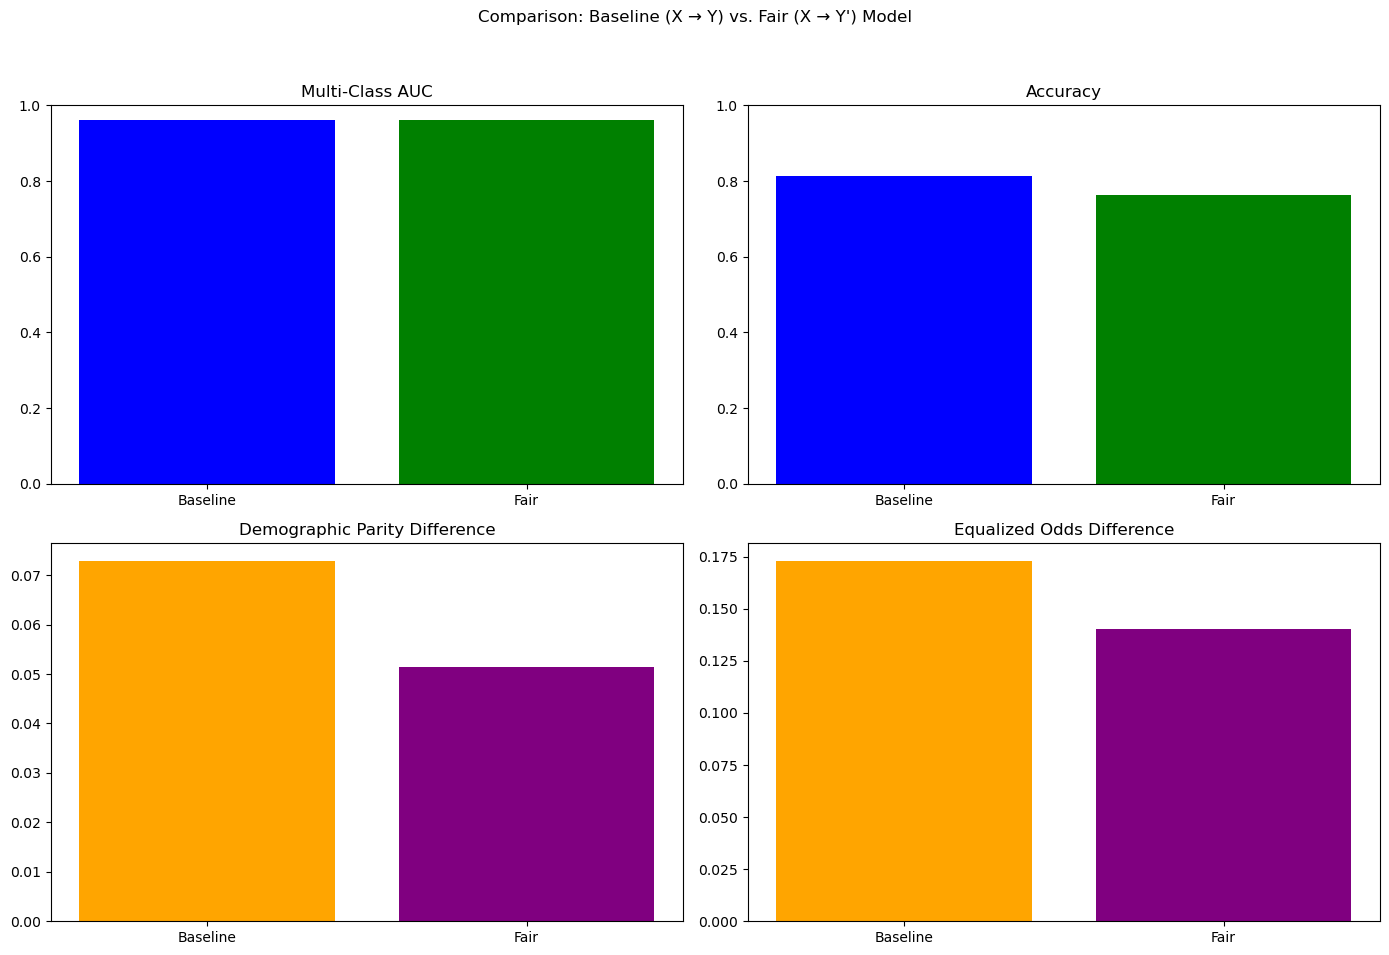

In [28]:
main_synthetic(lambda_adv=1.0, epochs=64, batch_size=128) # working the best now!
# main_synthetic(lambda_adv=1.0, epochs=64, batch_size=128)

In [ ]:
### last thing to do -- need to hypertune 
### need to do synthetic dataset for a multiclass

In [23]:
from sklearn.model_selection import StratifiedKFold
from itertools import product
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from tensorflow.keras.utils import to_categorical

class AdversarialModelWrapperFixed(BaseEstimator, ClassifierMixin):
    """
    Fixed Wrapper for Adversarial Model to work with Grid Search (Multi-Class).
    """

    def __init__(self, lambda_adv=1.0, epochs=64, batch_size=128):
        self.lambda_adv = lambda_adv
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y, S):
        """
        Train the adversarial model. S is passed dynamically per fold.
        """
        y = to_categorical(y, num_classes=4)  # Convert `y` to one-hot encoding for multi-class
        input_dim = X.shape[1]
        S_oh = tf.keras.utils.to_categorical(S, num_classes=2)

        # Ensure model is reinitialized for every run
        tf.keras.backend.clear_session()
        self.model = build_adversarial_model(input_dim, lambda_adv=self.lambda_adv)

        self.model.fit(
            [X, S_oh],
            {"pseudo_Y": y, "S_pred": S_oh, "Y_pred": y},
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0
        )
        return self

    def predict(self, X, S):
        """
        Generate predictions from the trained model. S must match X per fold.
        """
        S_oh = tf.keras.utils.to_categorical(S, num_classes=2)
        pseudo_Y, _, _ = self.model.predict([X, S_oh], verbose=0)
        return np.argmax(pseudo_Y, axis=1)  # Convert softmax probabilities to class predictions

    def score(self, X_train, Y_train_biased_pred, X_test, Y_test_biased_pred, Y_train_raw, Y_test_raw, S_train, S_test, return_metrics=False):
        """
        Compute the optimization score combining AUC, accuracy, and fairness metrics.
        """
        auc, acc, fairness_metrics = run_biased_logistic(
            X_train, Y_train_biased_pred, X_test, Y_test_biased_pred, 
            Y_train_raw, Y_test_raw, S_train, S_test
        )
        
        demographic_parity_diff = abs(fairness_metrics["demographic_parity_difference"])

        # Objective function (equal weights for now)
        score = auc + acc - demographic_parity_diff

        if return_metrics:
            return score, acc, auc, demographic_parity_diff
        return score


# Load synthetic dataset
set_seed(42)
X_train, X_test, Y_train_raw, Y_test_raw, S_train, S_test = generate_synthetic_data()
Y_train_biased, Y_test_biased = inject_bias(bias_factor=0.3, seed=42)

# Ensure `Y_train_biased` is a 1D array (convert categorical indices back)
Y_train_biased = Y_train_biased.ravel()

# Define hyperparameter grid
param_grid = {
    "lambda_adv": [1.0, 3.0, 5.0, 7.0, 15.0],
    "epochs": [32, 64, 128],
    "batch_size": [64, 128, 256]
}

# Custom cross-validation (Ensure stratification works correctly for multi-class)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=None)  # Removing fixed random_state

# Store results
results = []

# Perform manual grid search
for lambda_adv, epochs, batch_size in product(param_grid["lambda_adv"], param_grid["epochs"], param_grid["batch_size"]):
    scores, accuracies, aucs, demographic_parity_diffs = [], [], [], []
    
    print(f"\nTesting lambda_adv={lambda_adv}, epochs={epochs}, batch_size={batch_size}")
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, Y_train_biased)):  # Ensure Y_train_biased is used for stratification
        # Split data
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        Y_train_fold, Y_val_fold = Y_train_biased[train_idx], Y_train_biased[val_idx]
        S_train_fold, S_val_fold = S_train[train_idx], S_train[val_idx]

        # Train model
        model = AdversarialModelWrapperFixed(lambda_adv=lambda_adv, epochs=epochs, batch_size=batch_size)
        model.fit(X_train_fold, Y_train_fold, S=S_train_fold)

        # Evaluate model (Pass required arguments to `score`)
        score, accuracy, auc, demographic_parity_diff = model.score(
            X_train_fold, Y_train_fold, 
            X_val_fold, Y_val_fold, 
            Y_train_raw[train_idx], Y_train_raw[val_idx],  
            S_train_fold, S_val_fold, 
            return_metrics=True
        )

        # Debug: Check if predictions are changing
        preds = model.predict(X_val_fold, S_val_fold)
        print(f"Fold {fold + 1} - Sample Predictions: {np.unique(preds, return_counts=True)}")  # Ensure different classes appear

        # Store fold results
        scores.append(score)
        accuracies.append(accuracy)
        aucs.append(auc)
        demographic_parity_diffs.append(demographic_parity_diff)

        # Print results per fold
        print(f"  Fold {fold + 1}: Score={score:.4f}, Accuracy={accuracy:.4f}, AUC={auc:.4f}, Demographic Parity Diff={demographic_parity_diff:.4f}")

    # Store average scores across folds
    avg_score = np.mean(scores)
    avg_accuracy = np.mean(accuracies)
    avg_auc = np.mean(aucs)
    avg_demographic_parity_diff = np.mean(demographic_parity_diffs)

    results.append({
        "lambda_adv": lambda_adv,
        "epochs": epochs,
        "batch_size": batch_size,
        "score": avg_score,
        "accuracy": avg_accuracy,
        "auc": avg_auc,
        "demographic_parity_diff": avg_demographic_parity_diff
    })

    print(f"  Final (Avg) for lambda_adv={lambda_adv}, epochs={epochs}, batch_size={batch_size}: "
          f"Score={avg_score:.4f}, Accuracy={avg_accuracy:.4f}, AUC={avg_auc:.4f}, Demographic Parity Diff={avg_demographic_parity_diff:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find best hyperparameters
best_params = results_df.loc[results_df["score"].idxmax()]
print("\nBest Hyperparameters:", best_params)


Testing lambda_adv=1.0, epochs=32, batch_size=64
Fold 1 - Sample Predictions: (array([0, 1, 2, 3]), array([527, 180, 245, 382]))
  Fold 1: Score=1.7393, Accuracy=0.8223, AUC=0.9648, Demographic Parity Diff=0.0479
Fold 2 - Sample Predictions: (array([0, 1, 2, 3]), array([413, 249, 222, 449]))
  Fold 2: Score=1.6886, Accuracy=0.7989, AUC=0.9552, Demographic Parity Diff=0.0656
Fold 3 - Sample Predictions: (array([0, 1, 2, 3]), array([483, 174, 162, 514]))
  Fold 3: Score=1.7159, Accuracy=0.8005, AUC=0.9561, Demographic Parity Diff=0.0406
  Final (Avg) for lambda_adv=1.0, epochs=32, batch_size=64: Score=1.7146, Accuracy=0.8072, AUC=0.9587, Demographic Parity Diff=0.0514

Testing lambda_adv=1.0, epochs=32, batch_size=128
Fold 1 - Sample Predictions: (array([0, 1, 2, 3]), array([328, 239, 332, 435]))
  Fold 1: Score=1.6947, Accuracy=0.8006, AUC=0.9587, Demographic Parity Diff=0.0647
Fold 2 - Sample Predictions: (array([0, 1, 2, 3]), array([317, 374, 452, 190]))
  Fold 2: Score=1.6863, Accur